# Conservación de energía en flujo en tubería 1‐D

## Workshop - Introducción a OpenFOAM para la Ingeniería Química


<img src="../Documentacion/Figuras/Fig_1_Seccion_1.1_c.png" alt="Alternative text" 
     align="right"
     width="500"/> 

La ecuación en derivadas parciales en una dimensión que describe el problema de transferencia de calor de un fluido en una tubería circular y su calentamiento por convección natural (Figura 1) esta dada por:

$$\rho \hat{C}_p \frac{\partial T}{\partial t} = k \frac{\partial^2 T}{\partial x^2} - \rho \hat{C}_p v_0 \frac{\partial T}{\partial x} - \frac{4 h(T-T_\text{aire})}{d_i} $$

Con condiciones de borde:

$$ CB1: T(x=0) = T_{in}$$

$$ CB2: \frac{d T}{d x}(x = L) = 0$$

Y condición inicial:

$$ CI: T(x, t=0) = T_{in}$$

La versión discretizada de esta ecuación que obtuvimos al aplicar el [método de volúmenes finitos](https://github.com/openfoam-ICL-UC/openfoam_intro_ES/wiki/Conservaci%C3%B3n-de-energ%C3%ADa-en-flujo-en-tuber%C3%ADa-1%E2%80%90D) y considerando un esquema central para las derivadas espaciales y un esquema Eurler hacia adelante para la derivada temporal.

### Importar módulos

In [508]:
# Mejorar calidad de gráficos en Jupyter Notebook
#%matplotlib notebook

# Visualización de datos y gráficos
import matplotlib
import matplotlib.pyplot as plt 

# Computación numérica
import numpy as np

# Función para integración numérica
from scipy.integrate import solve_ivp

### Inicializar las variables y parámetros del problema

In [509]:
# Parámetros constantes conocidos

# Largo de la tubería / m
L = 1 #0.5

# Diámetro interno de la tubería / m
di = 0.0254*2

# Velocidad del fluido / m s^-1
u0 = 0.1

# Temperatura del aire / K
Taire = 273.15 + 25

# Temperatura de entrada del fluido / K
Tin = 70

# Coeficiente de transferencia de calor por convección natural / W m^-2 K^-1 
h = 25

# Propiedades del Nitrogeno liquido a 70 K y 1 atm
# Densidad del fluido / kg m^-3
rho = 838.645

# Viscosidad / Pa s
mu = 2.2e-4

# Conductividad termica / W m^-1 K^-1 
k = 0.16

# Capacidad calorífica a presión constante / J kg^-1 K^-1
Cp = 2014.03

# Difusividad térmica / m^2 s^-1
alpha = k / (rho * Cp) 

# Prandtl number Pr=(mu/rho)/alpha
Pr = (mu/rho)/alpha
print('Pr = %.3f' %Pr)

Pr = 2.769


### Generar la grilla 1-D y espaciamiento espacial

In [510]:
# Grilla en coordenada x a lo largo de la tubería

# Tupla que contiene el valor de x inicial y final
x_rango = (0, L)

# Número de puntos en la grilla
N = 100 #*10

# Espaciamiento espacial
dx = L/N
dx_half = dx/2


# Vector con coordenadas en x
# el vector x_grilla almacena las coordenadas de los puntos centrales (P) de cada volumen de control
x_grilla = np.linspace(dx_half, L-dx_half, N)

print('dx = ',dx)
print(x_grilla)

dx =  0.01
[0.005 0.015 0.025 0.035 0.045 0.055 0.065 0.075 0.085 0.095 0.105 0.115
 0.125 0.135 0.145 0.155 0.165 0.175 0.185 0.195 0.205 0.215 0.225 0.235
 0.245 0.255 0.265 0.275 0.285 0.295 0.305 0.315 0.325 0.335 0.345 0.355
 0.365 0.375 0.385 0.395 0.405 0.415 0.425 0.435 0.445 0.455 0.465 0.475
 0.485 0.495 0.505 0.515 0.525 0.535 0.545 0.555 0.565 0.575 0.585 0.595
 0.605 0.615 0.625 0.635 0.645 0.655 0.665 0.675 0.685 0.695 0.705 0.715
 0.725 0.735 0.745 0.755 0.765 0.775 0.785 0.795 0.805 0.815 0.825 0.835
 0.845 0.855 0.865 0.875 0.885 0.895 0.905 0.915 0.925 0.935 0.945 0.955
 0.965 0.975 0.985 0.995]


In [511]:
# Cell Peclet number
# for central differencing Pe = rho*u0/(rho*alpha/dx) < 2
Pe = rho*u0/((rho*alpha)/dx)
print('Cell Peclet numer = ',Pe)

Cell Peclet numer =  10556.601183437502


### Definiendo espaciamiento temporal

In [512]:
# Courant–Friedrichs–Lewy number
CFL_max = 1.0
dt_CFL = CFL_max * 2 * dx / u0
print('dt (CFL) <= %.2e' %dt_CFL)

# rho*Cp*dx/dt > 2*k/dx
dt_cond = rho*Cp*dx**2/(2*k)
print('dt (cond) <= %.2e' %dt_cond)

# Espaciamiento temporal
dt = min(dt_CFL,dt_cond)
dt = dt/5
print('dt %.2e' %dt)

# Tiempo inicial
t_inicial = 0.0

# Tiempo final
t_final = 12
print('final time = %.2e' %t_final)

if dt > t_final:
    dt = t_final/100
print('dt ',dt)

#if dt < 5e-2:
#    t_final = 1000*dt
#print('final time = %.2e' %t_final)

#Condición inicial de temperatura
T = np.ones(N) * Tin 

dt (CFL) <= 2.00e-01
dt (cond) <= 5.28e+02
dt 4.00e-02
final time = 1.20e+01
dt  0.039999999999999994


In [513]:
c = u0*dt/dx
print('c = %.2e' %c)
d = alpha*dt/(dx**2)
print('d = %.2e' %d)
print('FTCS stability condition: c^2 <= 2*d <= 1')
print('c^2 = %2.e' %(c**2))
print('2*d = %2.e' %(2*d))

c = 4.00e-01
d = 3.79e-05
FTCS stability condition: c^2 <= 2*d <= 1
c^2 = 2e-01
2*d = 8e-05


### Definir los coefficients de la matriz A y el vector b

La ecuación discretizada por el método de volúmenes finitos puede escribirse en forma matricial como:

$$ a_P \mathbf{T}^{n+1} = \mathbf{A}\mathbf{T}^{n} + \mathbf{b}$$

#### Discretización de volúmenes de control internos:

$$ \frac{\rho C_p \Delta x}{\Delta t} T_P^{n+1} = \left(-\frac{\rho C_p v_0}{2} + \frac{k}{\Delta x}\right)T_E^n + \left(\frac{\rho C_p v_0}{2} + \frac{k}{\Delta x}\right)T_W^n + \left(\frac{\rho C_p \Delta x}{\Delta t} -2\frac{k}{\Delta x} - \frac{4 h \Delta x}{d_i}\right)T_P^n + \frac{4 h\Delta x}{d_i}T_\text{aire}$$

Podemos definir los siquientes coeficientes:

$$ a_P T_P^{n+1} = a_E T_E^n + a_W T_W^n + a_P' T_P^n + S_u$$

$$ a_P = \frac{\rho C_p \Delta x}{\Delta t}$$

$$ a_E = -\frac{\rho C_p v_0}{2} + \frac{k}{\Delta x}$$

$$ a_W = \frac{\rho C_p v_0}{2} + \frac{k}{\Delta x}$$

$$ S_p = - \frac{4 h \Delta x}{d_i}$$

$$ a_P' = a_P - (a_E + a_W) + S_p$$

$$ S_u = \frac{4 h \Delta x}{d_i}T_\text{aire}$$

In [521]:
# Volúmenes de control internos
aP = rho*Cp*dx/dt

aE = -rho*Cp*u0/2 + k/dx

aW = rho*Cp*u0/2 + k/dx

Sp = -4*h*dx/di

aP_n = aP - (aE + aW) + Sp

Su = 4*h*Taire*dx/di

print('aP = %.1f' %aP)
print('aE = %.1f' %aE)
print('aW = %.1f' %aW)
print('aPn = %.1f' %aP_n)
print('|sum a_nb|/|aP_n| = %.2e' %(abs(aE+aW)/abs(aP_n)))

aP = 422264.0
aE = -84436.8
aW = 84468.8
aPn = 422212.4
|sum a_nb|/|aP_n| = 7.58e-05


#### Discretización de condición de borde 1 (CB1) en primer volumen de control:

$$T(x=0,t) = T_{in} \rightarrow T_{1-1/2}^n = T_{in}$$

Sustituyendo en la ecuacion discretizada:

$$ \frac{\rho C_p \Delta x}{\Delta t} T_1^{n+1} = \left(-\frac{\rho C_p v_0}{2} + \frac{k}{\Delta x}\right)T_2^n + \left(\frac{\rho C_p \Delta x}{\Delta t} -\frac{\rho C_p v_0}{2} -\frac{3 k}{\Delta x} - \frac{4 h \Delta x}{d_i}\right)T_1^n + \left(\rho C_p v_0 + \frac{2 k}{\Delta x}\right)T_{in} + \frac{4 h\Delta x}{d_i}T_\text{aire}$$

Reordenando términos:

$$ a_P = \frac{\rho C_p \Delta x}{\Delta t}$$

$$ a_E = -\frac{\rho C_p v_0}{2} + \frac{k}{\Delta x}$$

$$ a_W = 0$$

$$ S_p = - \left(\rho C_p v_0 + \frac{2 k}{\Delta x}\right) - \frac{4 h \Delta x}{d_i}$$

$$ a_P' = a_P - (a_E + a_W)  + S_p$$

$$ S_u = \frac{4 h \Delta x}{d_i}T_\text{aire}$$

In [515]:
# Volúmen de control en boundary x=0 
aP_bc1 = aP

aE_bc1 = aE

aW_bc1 = 0

Sp_bc1 = Sp

aP_n_bc1 = aP_bc1 -rho*Cp*u0/2 - 3*k/dx + Sp_bc1

Su_bc1 = (rho*Cp*u0 + 2*k/dx)*Tin + Su

print('aP (BC1) = %.1f' %aP_bc1)
print('aE (BC1) = %.1f' %aE_bc1)
print('aW (BC1) = %.1f' %aW_bc1)
print('|sum a_nb|/|aP_n| (BC1) = %.2e' %(abs(aE_bc1+aW_bc1)/abs(aP_n_bc1)))

aP (BC1) = 422264.0
aE (BC1) = -84436.8
aW (BC1) = 0.0
|sum a_nb|/|aP_n| (BC1) = 2.50e-01


#### Discretización de condicion de borde 2 (CB2) en último volumen de control:

$$\frac{d T}{d x}(x=L,t) = 0 \rightarrow \frac{T_{N+1/2} - T_{N}}{\Delta x/2} = 0 \rightarrow T_{N+1/2}^n = T_N^n$$

Sustituyendo en la ecuacion discretizada:

$$ \frac{\rho C_p \Delta x}{\Delta t} T_N^{n+1} = \left(\frac{\rho C_p v_0}{2} + \frac{k}{\Delta x}\right)T_{N+1}^n + \left(\frac{\rho C_p \Delta x}{\Delta t} +\frac{\rho C_p v_0}{2} -\frac{k}{\Delta x} - \frac{4 h \Delta x}{d_i}\right)T_N^n + \frac{4 h\Delta x}{d_i}T_\text{aire}$$

Reordenando términos:

$$ a_P = \frac{\rho C_p \Delta x}{\Delta t}$$

$$ a_E = 0$$

$$ a_W = \frac{\rho C_p v_0}{2} + \frac{k}{\Delta x}$$

$$ S_p = \rho C_p v_0 - \frac{4 h \Delta x}{d_i}$$

$$ a_P' = a_P - (a_E + a_W) + S_p $$

$$ S_u = \frac{4 h \Delta x}{d_i}T_{aire}$$

In [516]:
# Volúmen de control en boundary x=L
aP_bc2 = aP

aE_bc2 = 0

aW_bc2 = aW

Sp_bc2 = Sp

aP_n_bc2 = aP_bc2 + rho*Cp*u0/2 - k/dx  + Sp_bc2

Su_bc2 = Su

print('aP (BC2) = %.1f' %aP_bc2)
print('aE (BC2) = %.1f' %aE_bc2)
print('aW (BC2) = %.1f' %aW_bc2)
print('|sum a_nb|/|aP_n| (BC2) = %.2e' %(abs(aE_bc2+aW_bc2)/abs(aP_n_bc2)))

aP (BC2) = 422264.0
aE (BC2) = 0.0
aW (BC2) = 84468.8
|sum a_nb|/|aP_n| (BC2) = 1.67e-01


In [517]:
# Vector b
b = np.ones(len(T))
b[0] = Su_bc1
for i in range(1,N-1):
    b[i] = Su
b[-1] = Su_bc2

# Matriz de coeficientes
A = np.zeros([N, N])
A[0][0] = aP_n_bc1
A[0][1] = aE_bc1
for i in range(1,N-1):
    # Coeficientes del volúmen de control de la izquierda, (i-1)
    A[i, i-1] = aW
    
    # Coeficientes del volúmen de control central, i
    A[i, i] = aP_n
        
    # Coeficientes del volúmen de control de la derecha, i + 1
    A[i, i+1] = aE

A[N-1][N-1] = aP_n_bc2
A[N-1][N-2] = aW_bc2


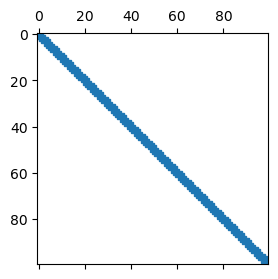

In [518]:
# Creamos un gráfico de 3 x 3
fig, ax = plt.subplots(1, 1, figsize = [3,3])

# Graficamos spy
ax.spy(A, markersize = 3)
plt.show()

### Iteración

In [519]:
# Lista con los perfiles de temperatura para cada write_interval
T_sol = []
T_sol.append(T)

T_old = np.copy(T)

# Ecuación de evolución desde t = 0 hasta t = tmax
t = 0

# Lista con los tiempos
times = []
times.append(0)

n = 1
while t < t_final:
    T_new = (np.dot(A,T_old) + b)*(1/aP)
    t += dt
    n += 1
    T_old = np.copy(T_new)
   
    # Almacenar soluciones en cada write_interval
    if round(n%10) == 0:
        T_sol.append(T_new)
        print(t)
        times.append(t)


0.3599999999999999
0.76
1.1600000000000004
1.5600000000000007
1.960000000000001
2.360000000000001
2.7600000000000016
3.160000000000002
3.5600000000000023
3.9600000000000026
4.360000000000003
4.760000000000003
5.160000000000004
5.560000000000004
5.960000000000004
6.360000000000005
6.760000000000005
7.1600000000000055
7.560000000000006
7.960000000000006
8.359999999999998
8.75999999999999
9.15999999999998
9.559999999999972
9.959999999999964
10.359999999999955
10.759999999999946
11.159999999999938
11.55999999999993
11.959999999999921


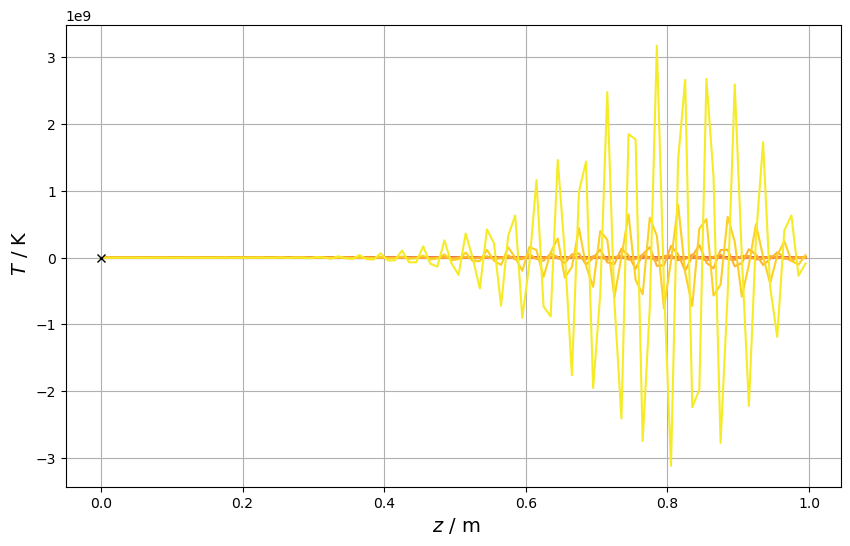

In [520]:
# Visualizar el perfil de temperatura
fig, ax = plt.subplots(1, 1, figsize = [10,6])

n_temp = len(T_sol)

plasma = matplotlib.colormaps['plasma']
colour = [plasma(i/n_temp) for i in range(n_temp)]

for j in range(0,len(T_sol),2):
    plt.plot(x_grilla, T_sol[j], color = colour[j], label = "t = %.0f s" % times[j])

plt.plot(0,Tin,'xk',)

plt.xlabel(' $z$ / m', size = 14)
plt.ylabel(' $T$ / K', size = 14)
plt.grid()
#plt.legend()
plt.show()